### Goal: Evaluation the time it take to compute CL lensing quantities using `cluster-toolkit` directly or the version wrapped into `CLMM` 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.cosmology import FlatLambdaCDM
import cluster_toolkit as ct
from clmm import modeling

#### Define a cosmology and fix cluster concentration

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
concentration = 4 #arbitrary
Omega_m = cosmo.Om0
R_perp = np.logspace(-2, 1, 30) #Mpc/h comoving; distance on the sky

#### Compare the brute force approach between `CT` and `CLMM`, calling the function for each cluster available

In [39]:
# Generate a population of random clusters
N_cl = int(1e4)
pop_cl_mass = np.random.uniform(1.e13,1.e16, N_cl)
pop_cl_z = np.random.uniform(0.1,1.2, N_cl)

def brute_force_CT():
    res = np.zeros([N_cl,len(R_perp)])
    sigma_r_proj = np.logspace(-3, 4, 1000) # this is so that CT runs in the same way as how it's called in CLMM
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        Om = Omega_m*(1+z)**3. # Need Omega_m(z) in cluster-toolkit
        Sigma_nfw = ct.deltasigma.Sigma_nfw_at_R(sigma_r_proj, mass, concentration, Om)
        res[i] = ct.deltasigma.DeltaSigma_at_R(R_perp, sigma_r_proj, Sigma_nfw, mass, concentration, Om)

    return res
        
def brute_force_CLMM():
    res = np.zeros([N_cl,len(R_perp)])
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        res[i] = modeling.predict_excess_surface_density(R_perp, mass, concentration, z, cosmo=cosmo, 
                                                delta_mdef=200, halo_profile_model='nfw')
    return res
        


In [30]:
%timeit brute_force_CT()

2.11 s ± 93.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
%timeit brute_force_CLMM()

2.87 s ± 69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Generate profiles on a grid before interpolating for each cluster in the population.

In [32]:
def grid_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp):
    sigma_r_proj = np.logspace(-3, 4, 1000) # this is so that CT runs in the same way as how it's called in CLMM
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            Om = Omega_m*(1+z)**3. # Need Omega_m(z) in cluster-toolkit
            Sigma_nfw = ct.deltasigma.Sigma_nfw_at_R(sigma_r_proj, mass, concentration, Om)
            res[i][j] = ct.deltasigma.DeltaSigma_at_R(R_perp, sigma_r_proj, Sigma_nfw, mass, concentration, Om)
    return res

def grid_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp):
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            res[i][j] = modeling.predict_excess_surface_density(R_perp, mass, concentration, z, cosmo=cosmo, 
                                                                 delta_mdef=200, halo_profile_model='nfw')
    return res       

def grid_clmm_gammat(cl_masses, cl_redshifts, src_z, R_perp):
    res = np.zeros([len(cl_masses), len(cl_redshifts), len(R_perp)])    
    for i,mass in enumerate(cl_masses):
        for j,z in enumerate(cl_redshifts):
            res[i][j] = modeling.predict_reduced_tangential_shear(R_perp, mdelta=mass, cdelta=concentration, 
                                                           z_cluster=z, z_source=src_z, cosmo=cosmo, 
                                                           delta_mdef=200, halo_profile_model='nfw', 
                                                           z_src_model='single_plane')   
    return res

#### Define the mass, redshifts and radius arrays.
- 30 radius bins
- 20 mass bins
- 20 redshifts bins

So, 400 function calls

In [40]:
cl_masses = np.logspace(13.,16.,30)
cl_redshifts = np.linspace(0.1,1.2,30)

#### Time to generate the interpolation table

In [41]:
%timeit res_ct_DeltaSigma = grid_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp)

213 ms ± 58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
%timeit res_clmm_DeltaSigma = grid_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp)

31.4 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It takes `CLMM` takes ~30% longer to generate the `DeltaSigma` profile than it does `cluster-toolkit`. Below, a sanity check to verify they did compute the same thing.

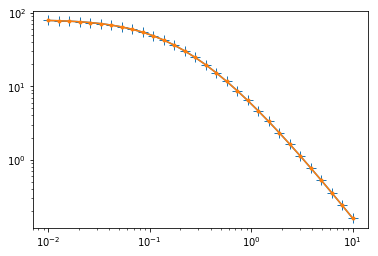

In [42]:
res_ct_DeltaSigma = grid_ct_DeltaSigma(cl_masses, cl_redshifts, R_perp)
res_clmm_DeltaSigma = grid_clmm_DeltaSigma(cl_masses, cl_redshifts, R_perp)
plt.loglog(R_perp, res_ct_DeltaSigma[1][2], marker='+', markersize=10)
plt.loglog(R_perp, res_clmm_DeltaSigma[1][2], marker = '.')

#### Given the grid of profiles, interpolate for each cluster of the population

In [43]:
from scipy import interpolate

def interpolation_CLMM():
    interp_func={}
    for i,R in enumerate(R_perp): # Need one interpolation func at each point of the profile
        interp_func[R] = interpolate.interp2d(np.log10(cl_masses), cl_redshifts, res_clmm_DeltaSigma[:,:,i], kind='cubic')

    res = np.zeros([N_cl,len(R_perp)])
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        res[i]=[interp_func[R](np.log10(mass),z)[0] for R in R_perp]

    return res

def interpolation_CT():
    interp_func={}
    for i,R in enumerate(R_perp):
        interp_func[R] = interpolate.interp2d(np.log10(cl_masses), cl_redshifts, res_ct_DeltaSigma[:,:,i], kind='cubic')

    res = np.zeros([N_cl,len(R_perp)])
    for i,(mass,z) in enumerate(zip(pop_cl_mass,pop_cl_z)):
        res[i]=[interp_func[R](np.log10(mass),z)[0] for R in R_perp]
        
    return res


In [26]:
%timeit interpolation_CT()

7.52 s ± 477 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit interpolation_CLMM()

6.2 s ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Checking that the interpolated profile look like profile on the first 10 clusters of the population

In [36]:
res_bruteforce = brute_force_CLMM()
res_interp = interpolation_CLMM()

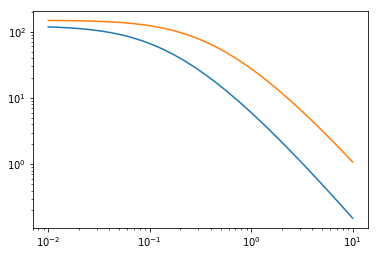

In [37]:
plt.loglog(R_perp,res_bruteforce[0])
plt.loglog(R_perp,res_interp[0])

In [63]:
%timeit interpolation_CT()

6.79 s ± 319 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Next things to do - use prun to identify where CLMM loses time...

#### CLMM tangential shear profile computation for the same mass and redshift grid and a single source plane.

In [164]:
z_src = 3.
%timeit res_clmm_gt = grid_clmm_gammat(cl_masses, cl_redshifts, z_src, R_perp)

569 ms ± 43.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The extra time compared to DeltaSigma comes from computing the angular diameter distances for Sigma_crit